## Introduction

The following is my solution for the Kaggle contest provided by Google: [ML Bootcamp Competition 2023 for Ukrainians](https://www.kaggle.com/competitions/ukraine-ml-bootcamp-2023).

#### Table of contents:
1. Introduction
2. Import the libraries
3. Import and explore the data
4. Data Preprocessing
5. Custom Evaluation Metric and Callbacks
6. Build and train the Model
7. Ensemble Models
8. Make predictions
9. Conclusion

#### About the competition

In this competition, we formulate the pose estimation as a classification task and you will have to classify different yoga asanas into different classes. You will be responsible for creating algorithms capable of performing a precise classification by aiming for higher Mean F1 scores. The dataset has pictures of different yoga poses and the class to which it belongs. There are a total of 6 classes based on the posture of the person performing the asana.

#### About the data set

The dataset provided in the train.csv consists of the following features:

- image_id: The unique ID for each image of yoga pose.
- class_6: The class to which each yoga pose image belongs. (target variable)

Understanding the Asanas:

The dataset at our disposal comprises images depicting different yoga poses, each assigned to one of six classes based on the posture of the individual executing the asana. These classes are as follows: Standing, Sitting, Balancing, Inverted, Reclining, and Wheel.

<div style="text-align:center;">
  <img src="yoga-82.png" alt="Yoga Poses" style="width:550px;" />
</div>

#### Acknowledgements

``` BibTeX
 @inproceedings{verma2020yoga,
  title={Yoga-82: A New Dataset for Fine-grained Classification of Human Poses},
  author={Verma, Manisha and Kumawat, Sudhakar and Nakashima, Yuta and Raman, Shanmuganathan},
  booktitle={IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW)},
  pages={4472-4479},
  year={2020}
}
```

#### Evaluation Metrics

The evaluation metric for this competition is Mean F1-Score. The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision "p" and recall "r". Submissions are evaluated on MeanFScore, which at Kaggle is actually a micro-averaged F1-score.

\begin{align*}
Precision_{micro} &= \frac{\text{TP}_{\text{total}}}{\text{TP}_{\text{total}} + \text{FNs}_{\text{total}}} \\ \\
Recall_{micro} &= \frac{\text{TP}_{\text{total}}}{\text{TP}_{\text{total}} + \text{FN}_{\text{total}}} \\
MeanFScore=F1_{micro} &= 2 \cdot \frac{Precision_{micro} \cdot Recall_{micro}}{Precision_{micro} + Recall_{micro}}
\end{align*}




The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

Namaste 🙏

## Import the libraries

In [1]:
# Importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math

# Importing the Keras libraries and packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Rescaling, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import Xception, EfficientNetV2S, DenseNet201

# Necessary to show Matplotlib's plots inside a Jupyter Notebook
%matplotlib inline

## Import and explore the data

In [2]:
train_csv_path = 'ukraine-ml-bootcamp-2023/train.csv'
train_images_path = 'ukraine-ml-bootcamp-2023/images/train_images/'
test_images_path = 'ukraine-ml-bootcamp-2023/images/test_images/'

In [3]:
# Read data from the 'train.csv' file into a DataFrame named 'df'
df = pd.read_csv(train_csv_path)
# Originally 'class_6' column contains numeric values but needs to be treated as strings
# Convert the 'class_6' column in 'df' to a string data type
df['class_6'] = df['class_6'].astype(str)

sample_submission_df = pd.read_csv('ukraine-ml-bootcamp-2023/sample_submission.csv')
sample_submission_df['class_6'] = sample_submission_df['class_6'].astype(str)

In [4]:
# The first 5 rows of the DataFrame "train_df"
df.head()

,image_id,class_6
0,1daf45401342ac321c0aa5668f51d004.jpg,5
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4
2,1dc97053cf67cb8e51c983abb0021083.jpg,4
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0


In [5]:
# Split train and validate 80/20
# Shuffle the DataFrame 'df' by sampling it with 'frac=1' to randomize the order of rows.
shuffled_df = df.sample(frac=1)
# Calculate the index at which to split the shuffled DataFrame for training and validation sets.
split_index = int(0.8 * len(shuffled_df))
# Use NumPy's split function to divide the shuffled DataFrame into two parts:
# 'train_df' with the first 80% of the data and 'validation_df' with the remaining 20%.
train_df, validation_df = np.split(shuffled_df, [split_index])

/Users/bulkobubulko/anaconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


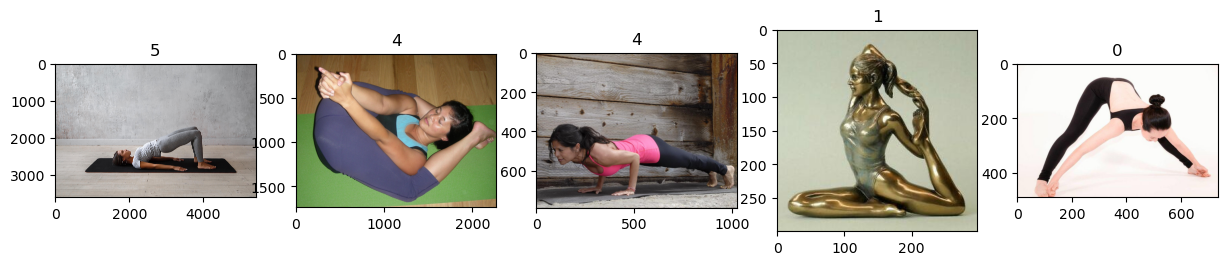

In [6]:
# Visualization of the first 5 images from the "df" DataFrame
fig = plt.figure(figsize=(15, 10))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    img = cv2.imread(train_images_path + df['image_id'][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(df['class_6'][i])

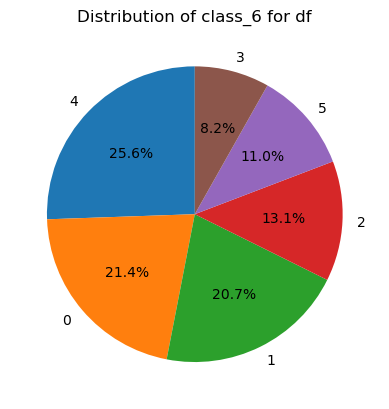

In [7]:
# Calculate the distribution of the 'class_6' column for DataFrame 'df'
class_counts = df['class_6'].value_counts()
# Create a figure and axis
fig, ax = plt.subplots()
# Plot the pie chart
ax.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of class_6 for df')
plt.show()

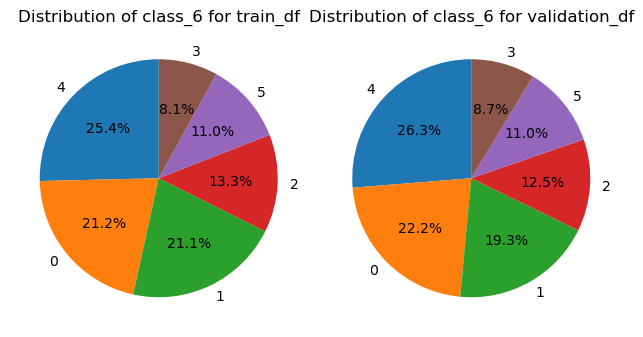

In [8]:
train_class_counts = train_df['class_6'].value_counts()
valid_class_counts = validation_df['class_6'].value_counts()
# Create a figure with two subplots arranged in one row and two columns
fig, (ax1, ax2) = plt.subplots(1, 2)
# Plot the pie chart for train_df on the left subplot (ax1)
ax1.pie(train_class_counts, labels=train_class_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Distribution of class_6 for train_df')
# Plot the pie chart for validation_df on the right subplot (ax2)
ax2.pie(valid_class_counts, labels=valid_class_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of class_6 for validation_df')
# Add spacing between the subplots
plt.tight_layout()
plt.show()

## Data Preprocessing

In [9]:
batch_size = 4
img_height = 224
img_width = 224
target_size = (img_height, img_width, 3)

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode='nearest',
    horizontal_flip=True)

validation_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_images_path,
    x_col='image_id',
    y_col='class_6',
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_height))

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=train_images_path,
    x_col='image_id',
    y_col='class_6',
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(img_height, img_width))

test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission_df,
    directory=test_images_path,
    x_col='image_id',
    y_col='class_6',
    batch_size=batch_size,
    class_mode=None,
    target_size=(img_height, img_width),
    shuffle=False)

Found 1888 validated image filenames belonging to 6 classes.
Found 472 validated image filenames belonging to 6 classes.
Found 756 validated image filenames.


## Custom Evaluation Metric and Callbacks

In [10]:
# Micro f1 score for categorical data
def micro_f1(y_true, y_pred):
    # Convert 'y_pred' into a one-hot encoded vector representing 
    # the predicted class with the highest confidence
    y_pred = K.one_hot(K.argmax(y_pred), num_classes=6) 
    # Get true positives, false positives, and false negatives
    tp = K.sum(K.cast(y_true*y_pred, "float32"), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, "float32"), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), "float32"), axis=0)
    # Compute precision, recall, f1
    p = K.sum(tp) / (K.sum(tp)+K.sum(fp)+K.epsilon())
    r = K.sum(tp) / (K.sum(tp)+K.sum(fn)+K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    return f1

In [11]:
# 1Cycle learning rate schedule: learning rate is increased during 
# the first half of training, then decreased in the second half.
def one_cycle_lr(epoch, lr):
    max_lr = 1e-4
    end_percentage = 0.1
    epochs = 50
    if epoch < 0.95 * epochs:
        return lr
    else:
        max_lr = max_lr * 0.1
        min_lr = max_lr * 0.001
        return min_lr + (max_lr - min_lr) * ((1 + math.cos(math.pi * (epoch - epochs * end_percentage) / (epochs * (1 - end_percentage)))) / 2)
    
one_cycle_lr_callback = LearningRateScheduler(one_cycle_lr, 
                                              verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               mode='min',
                               restore_best_weights= True)

callbacks = [one_cycle_lr_callback, early_stopping] 

## Build and train the Model

In [12]:
xception = Xception(
    weights="imagenet",
    input_shape=target_size,
    include_top=False,
)

# Freeze the base_model
xception.trainable = False

# Create new model on top
inputs = Input(shape=target_size)

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = xception(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs= Dense(6, activation = 'softmax')(x)
xception_model = Model(inputs, outputs)

2023-09-10 16:44:11.037410: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-10 16:44:11.037445: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-09-10 16:44:11.037452: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-09-10 16:44:11.037509: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-10 16:44:11.037537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
xception_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss='categorical_crossentropy', 
    metrics=['accuracy', micro_f1]
)

epochs = 50
xception_model_history = xception_model.fit(train_generator,
                                            epochs=epochs,
                                            callbacks=callbacks,
                                            validation_data=validation_generator)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50


2023-09-10 16:44:14.300103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - ETA: 0s - loss: 1.5222 - accuracy: 0.4041 - micro_f1: 0.4041

2023-09-10 16:45:30.046193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - 93s 192ms/step - loss: 1.5222 - accuracy: 0.4041 - micro_f1: 0.4041 - val_loss: 1.2351 - val_accuracy: 0.5445 - val_micro_f1: 0.5445 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
472/472 [==============================] - 85s 180ms/step - loss: 1.2223 - accuracy: 0.5477 - micro_f1: 0.5477 - val_loss: 1.1876 - val_accuracy: 0.5763 - val_micro_f1: 0.5763 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
472/472 [==============================] - 85s 181ms/step - loss: 1.1226 - accuracy: 0.5752 - micro_f1: 0.5752 - val_loss: 1.1126 - val_accuracy: 0.5932 - val_micro_f1: 0.5932 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
472/472 [==============================] - 85s 181ms/step - loss: 1.0510 - accuracy: 0.6054 - micro_f1: 0.6054 - val_loss: 1.1619 - val_accuracy: 0.5869 - val_m

In [14]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
xception.trainable = True
xception_model.summary()

xception_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy', 
    metrics=['accuracy', micro_f1]
)

epochs = 50
xception_model_history = xception_model.fit(train_generator, 
                                            epochs=epochs, 
                                            validation_data=validation_generator, 
                                            callbacks=callbacks)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                             

2023-09-10 17:04:35.083480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.7378 - micro_f1: 0.7378

2023-09-10 17:07:35.695506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - 199s 411ms/step - loss: 0.7183 - accuracy: 0.7378 - micro_f1: 0.7378 - val_loss: 0.9703 - val_accuracy: 0.6758 - val_micro_f1: 0.6758 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/50
472/472 [==============================] - 190s 403ms/step - loss: 0.4945 - accuracy: 0.8284 - micro_f1: 0.8284 - val_loss: 0.8907 - val_accuracy: 0.7140 - val_micro_f1: 0.7140 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/50
472/472 [==============================] - 185s 392ms/step - loss: 0.3665 - accuracy: 0.8713 - micro_f1: 0.8713 - val_loss: 0.9855 - val_accuracy: 0.6970 - val_micro_f1: 0.6970 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/50
472/472 [==============================] - 186s 393ms/step - loss: 0.2559 - accuracy: 0.9100 - micro_f1: 0.9100 - val_loss: 0.9403 - val_accuracy

In [16]:
efficientnetv2s = EfficientNetV2S(
    weights="imagenet",
    input_shape=target_size,
    include_top=False,
)

# Freeze the base_model
efficientnetv2s.trainable = False

# Create new model on top
inputs = Input(shape=target_size)

# For EfficientNetV2, by default input preprocessing is included as a part of the 
# model (as a Rescaling layer), and thus tf.keras.applications.efficientnet_v2.preprocess_input 
# is actually a pass-through function. In this use case, EfficientNetV2 models expect their 
# inputs to be float tensors of pixels with values in the [0-255] range.

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = efficientnetv2s(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs= Dense(6, activation = 'softmax')(x)
efficientnetv2s_model = Model(inputs, outputs)

In [17]:
efficientnetv2s_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss='categorical_crossentropy', 
    metrics=['accuracy', micro_f1]
)

epochs = 50
efficientnetv2s_model_history = efficientnetv2s_model.fit(train_generator, 
                                                          epochs=epochs, 
                                                          validation_data=validation_generator, 
                                                          callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50


2023-09-10 23:43:36.871137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - ETA: 0s - loss: 1.3735 - accuracy: 0.4730 - micro_f1: 0.4730

2023-09-10 23:44:41.330452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - 86s 162ms/step - loss: 1.3735 - accuracy: 0.4730 - micro_f1: 0.4730 - val_loss: 1.1942 - val_accuracy: 0.5593 - val_micro_f1: 0.5593 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
472/472 [==============================] - 67s 141ms/step - loss: 1.0867 - accuracy: 0.5996 - micro_f1: 0.5996 - val_loss: 1.0909 - val_accuracy: 0.6123 - val_micro_f1: 0.6123 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
472/472 [==============================] - 66s 141ms/step - loss: 0.9721 - accuracy: 0.6451 - micro_f1: 0.6451 - val_loss: 1.1186 - val_accuracy: 0.5657 - val_micro_f1: 0.5657 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
472/472 [==============================] - 67s 141ms/step - loss: 0.9214 - accuracy: 0.6690 - micro_f1: 0.6690 - val_loss: 1.0112 - val_accuracy: 0.6314 - val_m

In [18]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
efficientnetv2s.trainable = True
efficientnetv2s_model.summary()

efficientnetv2s_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy', 
    metrics=['accuracy', micro_f1]
)

epochs = 50
efficientnetv2s_model_history = efficientnetv2s_model.fit(train_generator, 
                                                          epochs=epochs, 
                                                          validation_data=validation_generator, 
                                                          callbacks=callbacks)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 20339046 (77.59 MB)
Trainable params: 2018517

2023-09-10 23:59:44.668546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.7950 - micro_f1: 0.7950

2023-09-11 00:04:09.563027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - 297s 550ms/step - loss: 0.5761 - accuracy: 0.7950 - micro_f1: 0.7950 - val_loss: 0.7710 - val_accuracy: 0.7182 - val_micro_f1: 0.7182 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/50
472/472 [==============================] - 222s 470ms/step - loss: 0.3294 - accuracy: 0.8851 - micro_f1: 0.8851 - val_loss: 0.7483 - val_accuracy: 0.7415 - val_micro_f1: 0.7415 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/50
472/472 [==============================] - 207s 439ms/step - loss: 0.1803 - accuracy: 0.9476 - micro_f1: 0.9476 - val_loss: 0.7389 - val_accuracy: 0.7691 - val_micro_f1: 0.7691 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/50
472/472 [==============================] - 194s 412ms/step - loss: 0.1080 - accuracy: 0.9703 - micro_f1: 0.9703 - val_loss: 0.7889 - val_accuracy

In [19]:
densenet201 = DenseNet201(
    weights="imagenet",
    input_shape=target_size,
    include_top=False,
)

# Freeze the base_model
densenet201.trainable = False

# Create new model on top
inputs = Input(shape=target_size, dtype = tf.uint8)
x = tf.cast(inputs, tf.float32)

# For DenseNet, call tf.keras.applications.densenet.preprocess_input 
# on your inputs before passing them to the model.
x = tf.keras.applications.densenet.preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = densenet201(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs= Dense(6, activation = 'softmax')(x)
densenet201_model = Model(inputs, outputs)

In [20]:
densenet201_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss='categorical_crossentropy', 
    metrics=['accuracy', micro_f1]
)

epochs = 50
densenet201_model_history = densenet201_model.fit(train_generator, 
                                                  epochs=epochs, 
                                                  callbacks=callbacks,
                                                  validation_data=validation_generator)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50


2023-09-11 00:28:05.202609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - ETA: 0s - loss: 1.6475 - accuracy: 0.3464 - micro_f1: 0.3464

2023-09-11 00:29:35.105617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - 124s 238ms/step - loss: 1.6475 - accuracy: 0.3464 - micro_f1: 0.3464 - val_loss: 1.3444 - val_accuracy: 0.4958 - val_micro_f1: 0.4958 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
472/472 [==============================] - 93s 196ms/step - loss: 1.3396 - accuracy: 0.4852 - micro_f1: 0.4852 - val_loss: 1.3119 - val_accuracy: 0.5360 - val_micro_f1: 0.5360 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
472/472 [==============================] - 94s 200ms/step - loss: 1.2109 - accuracy: 0.5376 - micro_f1: 0.5376 - val_loss: 1.2816 - val_accuracy: 0.5508 - val_micro_f1: 0.5508 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
472/472 [==============================] - 93s 197ms/step - loss: 1.1416 - accuracy: 0.5493 - micro_f1: 0.5493 - val_loss: 1.1610 - val_accuracy: 0.5445 - val_

In [21]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
densenet201.trainable = True
densenet201_model.summary()

densenet201_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy', 
    metrics=['accuracy', micro_f1]
)

epochs = 50
densenet201_model_history = densenet201_model.fit(train_generator, 
                                                  epochs=epochs, 
                                                  validation_data=validation_generator, 
                                                  callbacks=callbacks)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                           

2023-09-11 00:44:16.278848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - ETA: 0s - loss: 0.8993 - accuracy: 0.6637 - micro_f1: 0.6637

2023-09-11 00:52:27.422030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


472/472 [==============================] - 535s 1s/step - loss: 0.8993 - accuracy: 0.6637 - micro_f1: 0.6637 - val_loss: 0.8454 - val_accuracy: 0.7119 - val_micro_f1: 0.7119 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/50
472/472 [==============================] - 461s 978ms/step - loss: 0.5667 - accuracy: 0.7956 - micro_f1: 0.7956 - val_loss: 0.7131 - val_accuracy: 0.7542 - val_micro_f1: 0.7542 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/50
472/472 [==============================] - 454s 962ms/step - loss: 0.3662 - accuracy: 0.8718 - micro_f1: 0.8718 - val_loss: 0.6532 - val_accuracy: 0.8030 - val_micro_f1: 0.8030 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/50
472/472 [==============================] - 452s 958ms/step - loss: 0.2673 - accuracy: 0.9057 - micro_f1: 0.9057 - val_loss: 0.6502 - val_accuracy: 0

## Ensemble Models

In [24]:
# # Use the trained models to predict classes for test data
xception_pred = xception_model.predict(test_generator)
efficientnetv2s_pred = efficientnetv2s_model.predict(test_generator)
densenet201_pred = densenet201_model.predict(test_generator)

ensemble_pred = xception_pred + efficientnetv2s_pred + densenet201_pred

# Find the predicted classes by selecting the class with the highest probability for each prediction
# The 'np.argmax' function extracts the index (class) with the highest probability for each prediction along the specified axis.
predicted_classes = np.argmax(ensemble_pred, axis=1)

2023-09-11 08:58:06.063036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 29s 134ms/step


2023-09-11 08:58:36.301911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 34s 119ms/step


2023-09-11 08:59:10.539684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 40s 146ms/step


## Model Prediction


In [25]:
# Create a DataFrame named 'submission' from the 'sample_submission.csv' file
submission = pd.DataFrame({'image_id': sample_submission_df['image_id'],
                           'class_6': predicted_classes})

# Save the 'submission' DataFrame to a CSV file named 'submission.csv' without the DataFrame index
submission.to_csv('submission.csv', index=False)

# Display the 'submission' DataFrame to inspect the formatted predictions
submission.head()

,image_id,class_6
0,18c514201d4d375596eaf057d43faa73.jpg,5
1,742cd45c52ee2d9a4745b27e1c5426a3.jpg,1
2,4ebf97acccead03c17d564c6701403ae.jpg,4
3,3a0fe12ec506d9fe99c0e370bce7eeef.jpg,3
4,d3442c050dd87db8b926b449408d793a.jpg,0


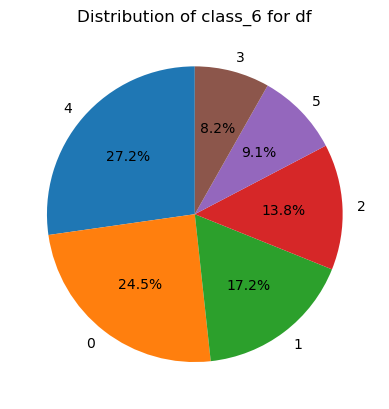

In [26]:
# Calculate the distribution of the 'class_6' column for DataFrame 'df'
class_counts = submission['class_6'].value_counts()

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the pie chart
ax.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of class_6 for df')
plt.show()

## Conclusion

- The attempt to remove the background using cv2 proved to be ineffective and resulted in the loss of valuable features. This process was later abandoned.

- Several image preprocessing techniques, including Image Denoising (Gaussian Blurring), Contrast Enhancement, Histogram Equalization, Edge Detection (Canny), and Thresholding, were explored. However, these techniques, as well as background removal, led to the potential loss of valuable features.

- A loooot was written, a looot was deleted, but in the end, I learned that simplicity often yields better results.

- Possible improvements: MoveNet

<3